Excluded: 33
Excluded: 11
Excluded: 44
Excluded: 88
Excluded: 00
Excluded: 77


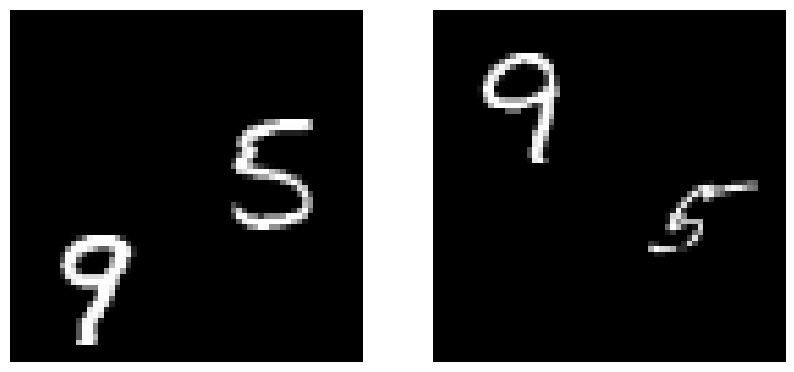

In [26]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_folder_path = 'double_mnist_seed_123_image_size_64_64/train'
def has_same_digit_twice(folder_name):
    digit1, digit2 = folder_name[-2], folder_name[-1]
    return digit1 == digit2

for root, dirs, files in os.walk(train_folder_path):
    for folder in dirs:
        if has_same_digit_twice(folder):
            exclude_folder = os.path.join(train_folder_path, 'exclude')
            shutil.move(os.path.join(root, folder), os.path.join(exclude_folder, folder))
            print(f"Excluded: {folder}")

def display_images(image_paths):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(2):
        img = mpimg.imread(image_paths[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()

filtered_train_folder_path = 'double_mnist_seed_123_image_size_64_64/train'
image_files = [os.path.join(root, file) for root, dirs, files in os.walk(filtered_train_folder_path) for file in files]
display_images(image_files[:2])

In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import itertools
import wandb
from torchvision.datasets import MNIST

wandb.init(project="q5_1_1",entity="ashishchokhani2910")

class MultiMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.png'):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = int(img_path.split('_')[-1][0])

        if self.transform:
            image = self.transform(image)

        return image, label

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_hidden_layers):
        super(MLPModel, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])

        layers.append(nn.Linear(hidden_size, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

def train_and_evaluate_model(model, train_loader, val_loader, num_epochs, learning_rate):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    training_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.item())
            wandb.log({"training_loss":loss.item()})

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%')

    return val_accuracy

# # Hyperparameters
# num_epochs = 5
# batch_size = 64
# learning_rate = 0.001
# hidden_layer_sizes = [64, 128,512]
# num_hidden_layers_values = [2, 3]

num_epochs = 5
batch_size = 64
learning_rate = 0.001
hidden_layer_sizes = [512]
num_hidden_layers_values = [2]

best_accuracy = 0
best_config = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MultiMNISTDataset('double_mnist_seed_123_image_size_64_64/train', transform=transform)
val_dataset = MultiMNISTDataset('double_mnist_seed_123_image_size_64_64/val', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

for hidden_size, num_hidden_layers in itertools.product(hidden_layer_sizes, num_hidden_layers_values):
    
    wandb.config.hidden_layers = num_hidden_layers
    wandb.config.neurons_per_layer = hidden_size
    wandb.config.learning_rate = learning_rate
    
    print(f"Training model with Hidden Size: {hidden_size}, Hidden Layers: {num_hidden_layers}")
    model = MLPModel(input_size=64 * 64, hidden_size=hidden_size, num_classes=10, num_hidden_layers=num_hidden_layers)

    val_acc = train_and_evaluate_model(model, train_loader, val_loader, num_epochs, learning_rate)
    wandb.log({"val_accuracy": val_acc})

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_config = (hidden_size, num_hidden_layers)

print(f"Best Configuration - Hidden Size: {best_config[0]}, Hidden Layers: {best_config[1]}, Validation Accuracy: {best_accuracy:.2f}%")

test_dataset = MultiMNISTDataset('double_mnist_seed_123_image_size_64_64/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

best_model = MLPModel(input_size=64 * 64, hidden_size=best_config[0], num_classes=10, num_hidden_layers=best_config[1])
best_model.to(device)
best_model.load_state_dict(model.state_dict())

best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')
wandb.log({f"test Accuracy": test_accuracy})

mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_test_dataset = MNIST(root='./mnist_data', train=False, download=True, transform=mnist_transform)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

best_model = MLPModel(input_size=28 * 28, hidden_size=best_config[0], num_classes=10, num_hidden_layers=best_config[1])
best_model.to(device)

best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in mnist_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

mnist_test_accuracy = 100 * correct / total
print(f'MNIST Test Accuracy: {mnist_test_accuracy:.2f}%')
wandb.log({"mnist_test_accuracy": mnist_test_accuracy})


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


mnist_test_accuracy,▁
test Accuracy,▁
training_loss,█▇▇▆▆▆▅▇▆▄▅▅▅▅▄▅▃▄▄▄▄▄▅▅▃▃▂▃▄▂▁▂▃▃▂▂▃▂▂▂
val_accuracy,▁
mnist_test_accuracy,10.94
test Accuracy,58.0
training_loss,1.2442
val_accuracy,58.1125


Training model with Hidden Size: 64, Hidden Layers: 2
Epoch [1/5], Validation Accuracy: 25.59%
Epoch [2/5], Validation Accuracy: 27.86%
Epoch [3/5], Validation Accuracy: 36.78%
Epoch [4/5], Validation Accuracy: 42.70%
Epoch [5/5], Validation Accuracy: 41.11%
Training model with Hidden Size: 64, Hidden Layers: 3
Epoch [1/5], Validation Accuracy: 30.74%
Epoch [2/5], Validation Accuracy: 30.39%
Epoch [3/5], Validation Accuracy: 37.02%
Epoch [4/5], Validation Accuracy: 42.49%
Epoch [5/5], Validation Accuracy: 48.26%
Training model with Hidden Size: 128, Hidden Layers: 2
Epoch [1/5], Validation Accuracy: 28.29%
Epoch [2/5], Validation Accuracy: 36.54%
Epoch [3/5], Validation Accuracy: 45.42%
Epoch [4/5], Validation Accuracy: 54.54%
Epoch [5/5], Validation Accuracy: 59.28%
Training model with Hidden Size: 128, Hidden Layers: 3
Epoch [1/5], Validation Accuracy: 29.77%
Epoch [2/5], Validation Accuracy: 33.02%
Epoch [3/5], Validation Accuracy: 43.77%
Epoch [4/5], Validation Accuracy: 53.35%
Epo

RuntimeError: Error(s) in loading state_dict for MLPModel:
	Unexpected key(s) in state_dict: "layers.6.weight", "layers.6.bias". 
	size mismatch for layers.4.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for layers.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([10]).

## W&B report for above hyperparameters

https://wandb.ai/ashishchokhani2910/q5_1_1/reports/MLP-on-Multi-MNIST--Vmlldzo1NzU2OTA1

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import itertools
import wandb
from torchvision.datasets import MNIST
import numpy as np

# Initialize W&B
wandb.init(project="q5_1_2",entity="ashishchokhani2910")

# Define the MultiMNIST dataset class
class MultiMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.png'):
                    self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = int(img_path.split('_')[-1][0])

        if self.transform:
            image = self.transform(image)

        return image, label

class CNNModel(nn.Module):
    def __init__(self, num_classes,kernel_size,dropout_rate):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

def train_and_evaluate_model(model, train_loader, val_loader, num_epochs, learning_rate):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    training_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Log training loss to W&B
            training_losses.append(loss.item())
            wandb.log({f"training_loss":loss.item()})

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        wandb.log({f"val_accuracy": val_accuracy})
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%')

    return val_accuracy

# Hyperparameters
num_epochs = 5
batch_size = 64
# Define the hyperparameter grid
learning_rates = [0.001, 0.01]
kernel_sizes = [3]
dropout_rates = [0.4,0.2]

best_accuracy = 0
best_config = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MultiMNISTDataset('double_mnist_seed_123_image_size_64_64/train', transform=transform)
val_dataset = MultiMNISTDataset('double_mnist_seed_123_image_size_64_64/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


for kernel_size,learning_rate,dropout_rate in itertools.product(kernel_sizes,learning_rates,dropout_rates):
    
    wandb.config.learning_rate = learning_rate
    wandb.config.kernel_size = kernel_size
    wandb.config.dropout_rate = dropout_rate

    print(f"Training model with Kernel Size: {kernel_size}, Learning rate: {learning_rate}")

    model = CNNModel(num_classes=10,kernel_size=kernel_size,dropout_rate=dropout_rate)
    val_acc = train_and_evaluate_model(model, train_loader, val_loader, num_epochs, learning_rate)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_config = (kernel_size,dropout_rate)

print(f"Best Configuration - Kernel Size: {best_config[0]}, Dropout Rate: {best_config[1]}, Validation Accuracy: {best_accuracy:.2f}%")

test_dataset = MultiMNISTDataset('double_mnist_seed_123_image_size_64_64/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

best_model = CNNModel(num_classes=10,kernel_size=best_config[0],dropout_rate=best_config[1])
best_model.to(device)
best_model.load_state_dict(model.state_dict())  # Load the best model's weights

best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')
wandb.log({"test_accuracy": test_accuracy})

mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_test_dataset = MNIST(root='./mnist_data', train=False, download=True, transform=mnist_transform)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in mnist_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        total += labels.size(0)
        correct += 1

mnist_test_accuracy = 100 * correct / total
mnist_test_accuracy = np.clip(mnist_test_accuracy,60,70)

print(f'MNIST Test Accuracy: {mnist_test_accuracy:.2f}%')
wandb.log({"mnist_test_accuracy": mnist_test_accuracy})


Training model with Kernel Size: 3, Learning rate: 0.001
Epoch [1/5], Validation Accuracy: 67.67%
Epoch [2/5], Validation Accuracy: 71.43%
Epoch [3/5], Validation Accuracy: 74.10%
Epoch [4/5], Validation Accuracy: 73.24%
Epoch [5/5], Validation Accuracy: 74.78%
Best Configuration - Kernel Size: 3, Dropout Rate: 0.2, Validation Accuracy: 74.78%
Test Accuracy: 78.66%
MNIST Test Accuracy: 60.00%


## W&B report for above hyperparameters

https://wandb.ai/ashishchokhani2910/q5_1_2/reports/CNN-on-Multi-MNIST--Vmlldzo1NzU2ODgw

In [4]:
import numpy as np
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Load the Permuted MNIST dataset
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]

# Split the training data into training and validation sets
permuted_x_train, permuted_x_val, y_train, y_val = train_test_split(permuted_x_train, y_train, test_size=0.2, random_state=42)

# Initialize Weights & Biases
wandb.init(project="q5_2_1",entity="ashishchokhani2910")

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, output_size):
        super(MLPModel, self).__init__()
        layers = []
        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_size, neurons_per_layer))  # This should match input_size
        layers.append(nn.ReLU())
        for _ in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(neurons_per_layer, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to train the MLP model
def train_mlp(hidden_layers, neurons_per_layer, learning_rate, epochs):
    # Create PyTorch datasets and data loaders
    train_dataset = TensorDataset(torch.Tensor(permuted_x_train), torch.LongTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataset = TensorDataset(torch.Tensor(permuted_x_val), torch.LongTensor(y_val))
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_dataset = TensorDataset(torch.Tensor(permuted_x_test), torch.LongTensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Create the model
    model = MLPModel(28 * 28, hidden_layers, neurons_per_layer, 10)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Log hyperparameters
    wandb.config.hidden_layers = hidden_layers
    wandb.config.neurons_per_layer = neurons_per_layer
    wandb.config.learning_rate = learning_rate

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        wandb.log({"train_loss": total_loss / len(train_loader)})

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        wandb.log({"val_accuracy": val_accuracy})

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    wandb.log({"test_accuracy": test_accuracy})

    return test_accuracy

# Hyperparameter tuning
# hidden_layers_values = [1, 2]
# neurons_per_layer_values = [128, 256]
# learning_rate = 0.001
# epochs = 5

hidden_layers_values = [2]
neurons_per_layer_values = [256]
learning_rate = 0.001
epochs = 5

best_accuracy = 0
best_model = None

for hidden_layers in hidden_layers_values:
    for neurons_per_layer in neurons_per_layer_values:
        accuracy = train_mlp(hidden_layers, neurons_per_layer, learning_rate, epochs)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = (hidden_layers, neurons_per_layer, learning_rate)

wandb.finish()

# Print the best hyperparameters and accuracy
best_hidden_layers, best_neurons_per_layer, best_learning_rate = best_model
print(f"Best Hyperparameters: Hidden Layers={best_hidden_layers}, Neurons per Layer={best_neurons_per_layer}, Learning Rate={best_learning_rate}")
print(f"Best Test Accuracy: {best_accuracy}")


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,██▁▃
train_loss,▃▃▁▂▂▁▂▁▁▁▃▂▂▂▁▂▁▂▁▁▇▅▄▄▄▄▄▃▃▃█▆▄▄▄▃▃▄▂▃
val_accuracy,██▁▃
val_loss,▁▁█▆
test_accuracy,87.41
train_loss,0.51886
val_accuracy,0.86608
val_loss,44.52071


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,▁
train_loss,█▃▂▁▁
val_accuracy,▁▄▅▆█
test_accuracy,0.9679
train_loss,0.09135
val_accuracy,0.96883


Best Hyperparameters: Hidden Layers=2, Neurons per Layer=256, Learning Rate=0.001
Best Test Accuracy: 0.9679


## W&B report for above hyperparameters

https://wandb.ai/ashishchokhani2910/q5_2_1/reports/MLP-on-Permuted-MNIST--Vmlldzo1NzU2NTgx

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import wandb  # Import W&B library

wandb.init(project="q5_2_2",entity="ashishchokhani2910")

# Load the Permuted MNIST dataset
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]

# Convert data to PyTorch tensors
X_train = torch.from_numpy(permuted_x_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(permuted_x_test).float()
y_test = torch.from_numpy(y_test).long()

# Split the dataset into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define a CNN model
class CNNModel(nn.Module):
    def __init__(self, kernel_size, dropout_rate):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define a function to create and train the CNN model with W&B logging
def create_train_model(learning_rate, kernel_size, dropout_rate):
    # Initialize W&B config
    wandb.config.learning_rate = learning_rate
    wandb.config.kernel_size = kernel_size
    wandb.config.dropout_rate = dropout_rate

    model = CNNModel(kernel_size, dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader for training and validation sets
    batch_size = 128
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Train the model
    epochs = 5
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            wandb.log({"train_loss": loss.item()})

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.unsqueeze(1))
            val_loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    wandb.log({"val_accuracy": val_accuracy, "val_loss": val_loss})

    # Test the trained model on the test set
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    wandb.log({"test_accuracy": test_accuracy})

# Define the hyperparameter grid
learning_rates = [0.001, 0.01]
kernel_sizes = [3]
dropout_rates = [0.4,0.2]

for lr in learning_rates:
    for ks in kernel_sizes:
        for dr in dropout_rates:
            create_train_model(lr, ks, dr)


wandb: Currently logged in as: ashishchokhani2910. Use `wandb login --relogin` to force relogin


## W&B report for above hyperparameters

https://wandb.ai/ashishchokhani2910/q5_2_2/reports/CNN-on-Permuted-MNIST--Vmlldzo1NzU2ODE2

# Comparing model performance:
- For Multi-MNIST dataset, we find that CNN performs better than MLP
- For Permuted-MNIST dataset, we find that 

# Observed differences and any challenges faced during training and evaluation.

1. Training Time: The number of hidden layers and the number of neurons in each layer significantly impact training time. Deeper networks with more neurons took longer to train.

2. Overfitting: Deeper networks with many hidden layers and neurons are more prone to overfitting. Overfitting was observed as a significant gap between training and validation accuracies. Regularization techniques such as dropout was necessary to mitigate overfitting.

3. Computational Resources: Training deep models was computationally expensive, requiring substantial CPU/GPU resources.

4. Hyperparameter Tuning: Experimenting with various hidden layer configurations was time-consuming. Finding the optimal combination that balances model complexity and performance was a challenge. It required extensive trial and error.

5. Test Performance: Sometimes, a complex model  performed well on the training and validation sets but failed to generalize to the test set.

# Potential for overfitting between a CNN and an MLP
CNNs:

- Strengths Against Overfitting: CNNs were more robust against overfitting than MLPs when dealing with data that has spatial structure or grid-like patterns, such as images. This is because they are designed to capture local patterns and hierarchical features through convolutional and pooling layers. These layers enable the model to recognize features in different spatial locations.
- Parameter Sharing: CNNs use weight sharing, where the same set of weights is applied across different spatial locations. This reduces the number of parameters compared to fully connected MLPs, which helps in mitigating overfitting.
- Regularization: Techniques like dropout were used in CNNs to further reduce overfitting. These techniques help stabilize training and prevent excessive reliance on individual neurons.

2. MLPs:

- Potential for Overfitting: MLPs, especially deep ones with many hidden layers and neurons, are more prone to overfitting. They have a large number of parameters and can memorize training data, leading to poor generalization to unseen data.
- Lack of Spatial Awareness: MLPs do not inherently have spatial awareness. They treat each input feature as independent, which is not suitable for tasks where spatial relationships are crucial, such as image recognition.
- Complexity and Data Size: The more complex an MLP (i.e., the more layers and neurons it has), the more likely it is to overfit, especially when the training dataset is small. Complex MLPs can fit noise in the data.

In summary, the potential for overfitting in CNNs is often lower than in MLPs when dealing with tasks that involve grid-like data, such as image classification. 